# Semestral project for MFF UK - Marketing

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import cx_Oracle
import json
from matplotlib.backends.backend_pdf import PdfPages
import os
import functools  #reduce

***The dataset we will be working with can be found at:*** [Kaggle](https://www.kaggle.com/datasets/imakash3011/customer-personality-analysis)

*Github of the project is currently private, but will be published once it is finished*

### About the dataset

It is concerned with the results of a broad marketing campaign across more than 2000 participants. The dataset includes some metadata about the respondents familial background - such as Income, Marital status, or whether there are teenagers living in the household - and details about the purchased data - whether the products were bought as a part of a deal, their quantities, and others. We will be analysing this dataset in a comprehensive manner, examining different quantities, looking for correlations, identifying different groups of citizens that are more prone to certain products, and more.

Now, let us finally open our data:

In [3]:
campaign = pd.read_csv('data/marketing_campaign.csv', sep='\t')
campaign.fillna(campaign.median(numeric_only=True).round(0), inplace=True)
campaign.head(10)

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0
5,7446,1967,Master,Together,62513.0,0,1,09-09-2013,16,520,...,6,0,0,0,0,0,0,3,11,0
6,965,1971,Graduation,Divorced,55635.0,0,1,13-11-2012,34,235,...,6,0,0,0,0,0,0,3,11,0
7,6177,1985,PhD,Married,33454.0,1,0,08-05-2013,32,76,...,8,0,0,0,0,0,0,3,11,0
8,4855,1974,PhD,Together,30351.0,1,0,06-06-2013,19,14,...,9,0,0,0,0,0,0,3,11,1
9,5899,1950,PhD,Together,5648.0,1,1,13-03-2014,68,28,...,20,1,0,0,0,0,0,3,11,0


Now that our data is loaded, let us see gow many respondents there actually are, as well as examine the distributions of education, of marital status, and of kid amounts, to get a rough idea with what groups of people we are dealing with.

There are 2240 entries and 29 columns


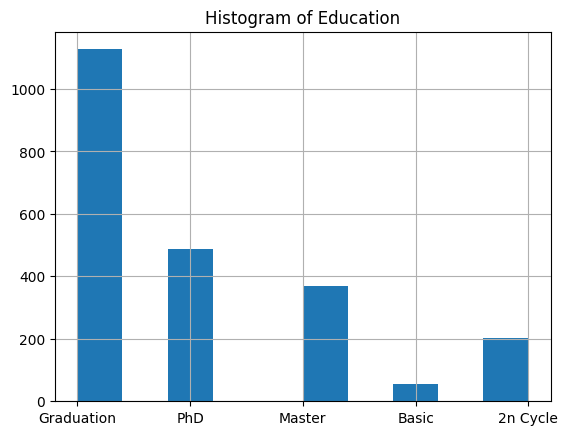

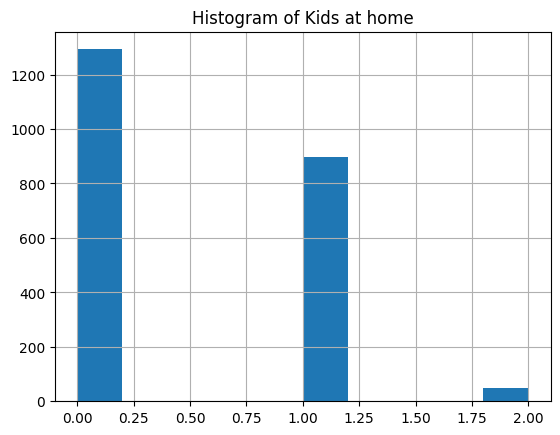

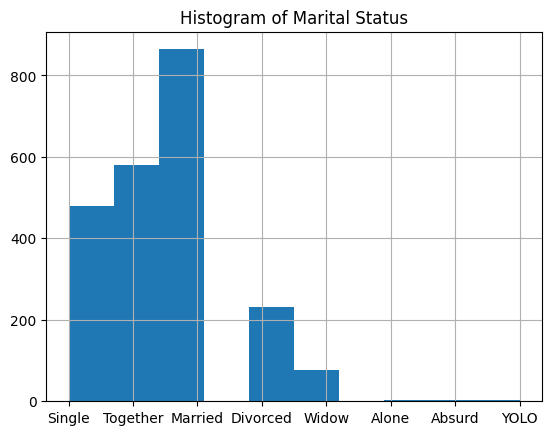

In [4]:
print('There are {} entries and {} columns'.format(campaign.shape[0], campaign.shape[1]))
ed_hist = campaign['Education'].hist()
plt.title('Histogram of Education')
plt.show()

kids_hist = campaign['Kidhome'].hist()
plt.title('Histogram of Kids at home')
plt.show()

ed_hist = campaign['Marital_Status'].hist()
plt.title('Histogram of Marital Status')
plt.show()

And manually for income:

In [5]:
np.max(campaign['Income'])

666666.0

(array([1678,  554,    7,    0,    0,    0,    0,    0,    0,    1],
      dtype=int64), array([  1730. ,  68223.6, 134717.2, 201210.8, 267704.4, 334198. ,
       400691.6, 467185.2, 533678.8, 600172.4, 666666. ]))


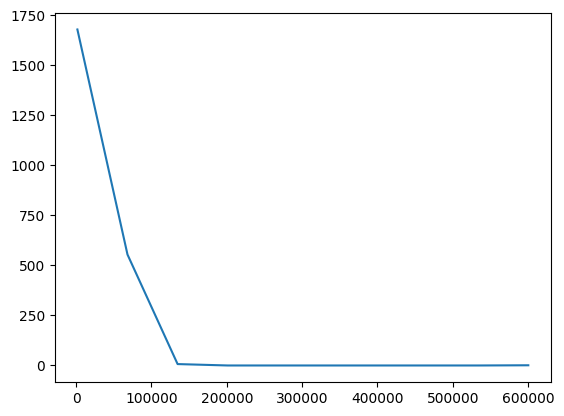

In [6]:
bins = [10**i for i in range(1,5)]
inc_hist = np.histogram(campaign['Income'])
print(inc_hist)

plt.plot(inc_hist[1][:-1], inc_hist[0])
plt.show()

As expected, Income follows the famous Pareto distribution, having a handful of disproportianetly high-earners with the majority at the bottom.

*Note that we attempted to plot the bar of this income distribution, but the bar did not show.*

Let us now compare the amount of teenagers versus kids our respondents are responsible for.

Text(0.5, 1.0, 'Respondent family situation')

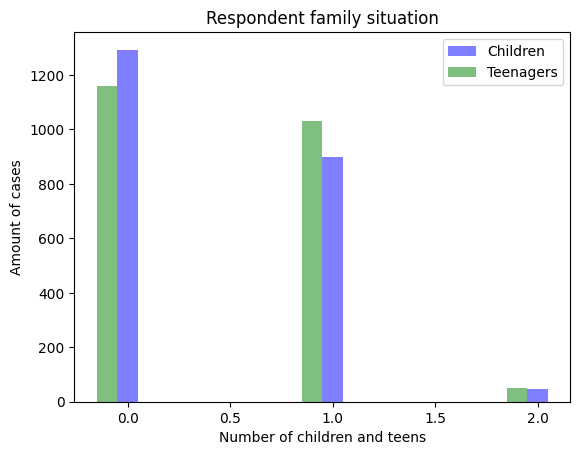

In [7]:
kid_values= list(set(campaign['Kidhome']))
kid_values.sort()
bb=[0]+[i+0.1 for i in kid_values]
plt.bar(kid_values, np.histogram(campaign['Kidhome'], bins=bb)[0], width=0.1, alpha=0.5, color='blue', label='Children')
plt.bar([(i-0.1) for i in kid_values], np.histogram(campaign['Teenhome'], bins=bb)[0], width=0.1, alpha=0.5, color='green', label='Teenagers')
plt.xlabel('Number of children and teens')
plt.ylabel('Amount of cases')
plt.legend()
plt.title('Respondent family situation')

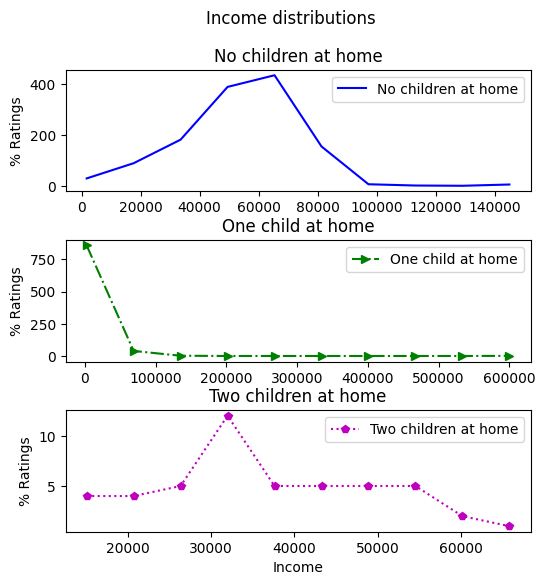

In [8]:
def ukaz(ax,data,text, color):
    plt.title(text)
    inc_hist = np.histogram(data['Income'])

    plt.plot(inc_hist[1][:-1], inc_hist[0], color, label=text)
    plt.legend()
    plt.ylabel('% Ratings')

no_kid = campaign['Kidhome'] == 0
one_kid = campaign['Kidhome'] == 1
two_kid = campaign['Kidhome'] == 2

fig, ax_lst = plt.subplots(3, 1, figsize=(6, 6))  # 3 rows, 1 column; numbered row-wise
fig.subplots_adjust(hspace=0.4, wspace=0.4)
fig.suptitle('Income distributions')  # Add a title so we know which it is
sub1=plt.subplot(311)
ukaz(plt, campaign[no_kid],'No children at home','-b')
ax2=plt.subplot(312)
ukaz(plt, campaign[one_kid],'One child at home','>-.g')
plt.subplot(313)
ukaz(plt, campaign[two_kid],'Two children at home','p:m')
plt.xlabel('Income')
plt.show()

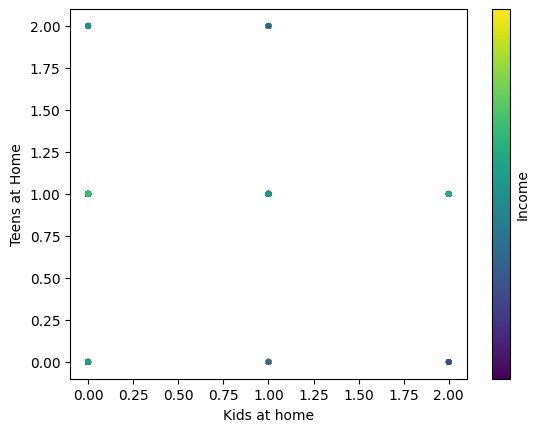

In [9]:
plt.scatter(campaign['Kidhome'], campaign['Teenhome'], c=campaign['Income'], s=np.log(campaign['Income']))
plt.xlabel('Kids at home')
plt.ylabel('Teens at Home')
cbar=plt.colorbar(ticks=range(6))
plt.clim(1000, 100000)
cbar.set_label('Income', rotation=90)
plt.show()

This plot perhaps wasn't the best of plots, but it was certainly informative :D

We unfortunately don't have the kind of data that would fit our scatterplot well, so we will settle for this. Let's now take a look at marital status instead.

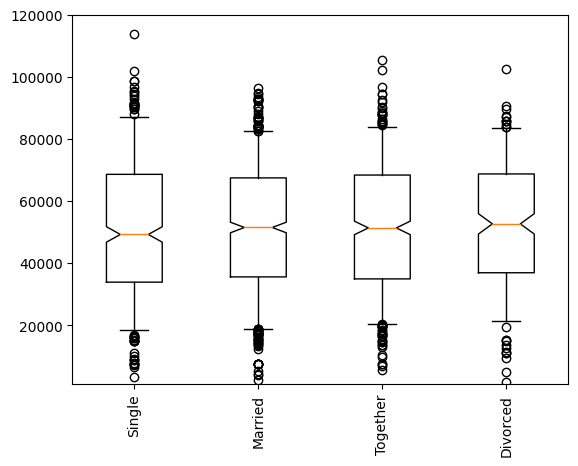

In [10]:
single = campaign['Marital_Status'] == 'Single'
married = campaign['Marital_Status'] == 'Married' 
together = campaign['Marital_Status'] == 'Together'
divorced = campaign['Marital_Status'] == 'Divorced'

nic=plt.boxplot(np.array([campaign[single].Income, campaign[married].Income, campaign[together].Income, campaign[divorced].Income],dtype=object),
                notch=True,
                whis=(5, 95))
plt.xticks([ 1, 2, 3, 4], ['Single','Married','Together', 'Divorced'],rotation=90)
plt.ylim([1000, 120000])
plt.grid(False)
plt.show()

Let us now examine some numbers of bought items for a change. Meaning number of items bought via the web, number of items bought via a catalogue, and number of items bought via Stores.

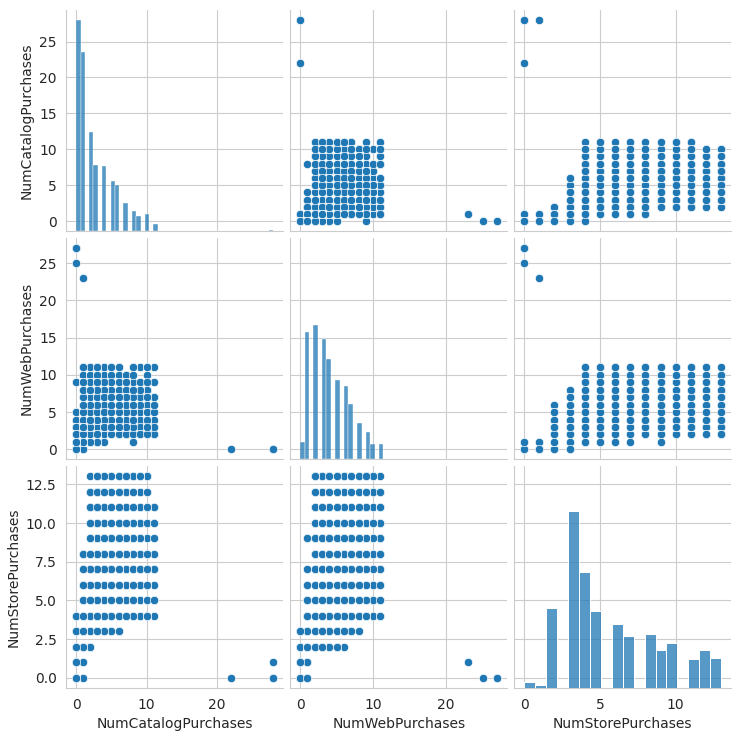

In [11]:
with sns.axes_style(style='whitegrid'):#{darkgrid, whitegrid, dark, white, ticks}
    sns.pairplot(campaign[['NumCatalogPurchases','NumWebPurchases','NumStorePurchases']], height=2.5)
plt.show()

## Lab 3 iteration

_This lab focused on data aggregation by features and operation broadcasting._

Let's start by taking a look at some of our product purchases aggregates, starting with number of complaints recieved.

In [12]:
print('We recieved a total of {} complaints from customers.'.format(campaign.Complain.sum()))

We recieved a total of 21 complaints from customers.


Let us now examine if the respondents marital status had any impact on their willingness to complain:

In [13]:
campaign.groupby('Marital_Status')['Complain'].sum()

Marital_Status
Absurd      0
Alone       0
Divorced    2
Married     8
Single      6
Together    5
Widow       0
YOLO        0
Name: Complain, dtype: int64

This might seem like marriage indeed makes people more irritable, but let us not forget - there are notably more married respondents than any other group in our dataset.

In [14]:
campaign.groupby('Marital_Status')['Complain'].mean()

Marital_Status
Absurd      0.000000
Alone       0.000000
Divorced    0.008621
Married     0.009259
Single      0.012500
Together    0.008621
Widow       0.000000
YOLO        0.000000
Name: Complain, dtype: float64

So in reality, it is being single that's most correlated with a bad mood ;)

Let us instead see how many web purchases one is likely to make based on his marital status.

In [15]:
campaign.groupby('Marital_Status')['NumWebPurchases'].aggregate(['mean', 'median', 'sum'])

,mean,median,sum
Marital_Status,,,
Absurd,3.500000,3.5,7
Alone,5.000000,3.0,15
Divorced,4.310345,4.0,1000
Married,4.087963,4.0,3532
Single,3.872917,3.0,1859
Together,4.081034,4.0,2367
Widow,4.623377,4.0,356
YOLO,7.000000,7.0,14


This is rather surprising, as one would expect Singles, who are no doubt younger on average, to take the lead in this category.

Let us now get an overview of what kind of purchases what groups are more likely to make.

In [16]:
campaign.groupby('Marital_Status')[['NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth']].aggregate(['mean', 'median', 'sum', 'count'])

NumDealsPurchases                    NumWebPurchases         \
                            mean median   sum count            mean median   
Marital_Status                                                               
Absurd                  2.000000    2.0     4     2        3.500000    3.5   
Alone                   3.666667    4.0    11     3        5.000000    3.0   
Divorced                2.435345    2.0   565   232        4.310345    4.0   
Married                 2.392361    2.0  2067   864        4.087963    4.0   
Single                  2.131250    1.0  1023   480        3.872917    3.0   
Together                2.324138    2.0  1348   580        4.081034    4.0   
Widow                   2.337662    2.0   180    77        4.623377    4.0   
YOLO                    5.000000    5.0    10     2        7.000000    7.0   

                           NumCatalogPurchases                     \
                 sum count                mean median   sum count   
Marital_Status                                                      
Absurd             7     2            7.500000    7.5    15     2   
Alone             15     3            0.666667    1.0     2     3   
Divorced        1000   232            2.672414    2.0   620   232   
Married         3532   864            2.625000    2.0  2268   864   
Single          1859   480            2.600000    2.0  1248   480   
Together        2367   580            2.675862    2.0  1552   580   
Widow            356    77            3.324675    3.0   256    77   
YOLO              14     2            1.000000    1.0     2     2   

               NumStorePurchases                    NumWebVisitsMonth         \
                            mean median   sum count              mean median   
Marital_Status                                                                 
Absurd                  6.500000    6.5    13     2          1.500000    1.5   
Alone                   4.000000    4.0    12     3          6.333333    6.0   
Divorced                5.818966    5.0  1350   232          5.487069    6.0   
Married                 5.850694    5.0  5055   864          5.364583    6.0   
Single                  5.639583    4.0  2707   480          5.283333    6.0   
Together                5.736207    5.0  3327   580          5.260345    5.5   
Widow                   6.415584    6.0   494    77          4.883117    5.0   
YOLO                    6.000000    6.0    12     2          8.000000    8.0   

                            
                 sum count  
Marital_Status              
Absurd             3     2  
Alone             19     3  
Divorced        1273   232  
Married         4635   864  
Single          2536   480  
Together        3051   580  
Widow            376    77  
YOLO              16     2

In [17]:
campaign.groupby('Education')[['NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth']].aggregate(['mean', 'median', 'sum', 'count'])

NumDealsPurchases                    NumWebPurchases               \
                        mean median   sum count            mean median   sum   
Education                                                                      
2n Cycle            2.246305    2.0   456   203        3.729064    3.0   757   
Basic               1.796296    1.0    97    54        1.888889    2.0   102   
Graduation          2.309672    2.0  2603  1127        4.125111    4.0  4649   
Master              2.427027    2.0   898   370        4.032432    3.0  1492   
PhD                 2.374486    2.0  1154   486        4.423868    4.0  2150   

                 NumCatalogPurchases                    NumStorePurchases  \
           count                mean median   sum count              mean   
Education                                                                   
2n Cycle     203            2.320197    1.0   471   203          5.507389   
Basic         54            0.481481    0.0    26    54          2.851852   
Graduation  1127            2.725821    2.0  3072  1127          5.829636   
Master       370            2.570270    2.0   951   370          5.897297   
PhD          486            2.969136    2.0  1443   486          6.061728   

                              NumWebVisitsMonth                     
           median   sum count              mean median   sum count  
Education                                                           
2n Cycle      4.0  1118   203          5.453202    6.0  1107   203  
Basic         3.0   154    54          6.870370    7.0   371    54  
Graduation    5.0  6570  1127          5.287489    6.0  5959  1127  
Master        5.0  2182   370          5.178378    6.0  1916   370  
PhD           5.0  2946   486          5.259259    5.0  2556   486

Among other things, we can spot the overall lowest mean in all purchasing categories by customers with only a basic education, yet they seem to compose most store visits. Could this be due to a lower income?

In [18]:
campaign.groupby('Education')[['Income']].aggregate(['mean', 'median', 'sum', 'count'])

Income                           
                    mean   median         sum count
Education                                          
2n Cycle    47688.591133  46891.0   9680784.0   203
Basic       20306.259259  20744.0   1096538.0    54
Graduation  52707.310559  51651.0  59401139.0  1127
Master      52896.783784  51044.5  19571810.0   370
PhD         56096.308642  55005.0  27262806.0   486

Go to school kids.

Now let's do one more complex query

         total_spending
Recency                
0                 12601
1                 15864
2                 17330
3                 18486
4                 17953


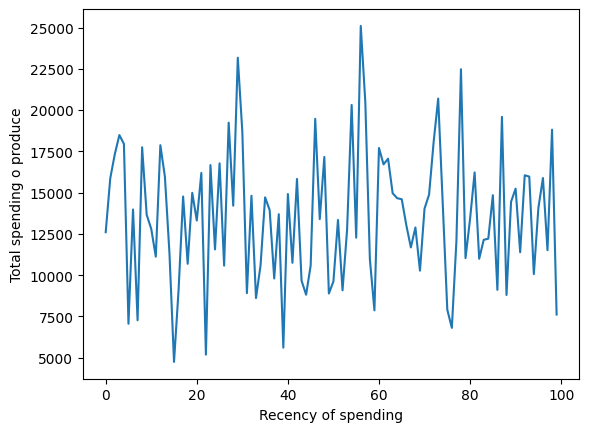

In [41]:
def f(x):
    d = {}
    d['total_spending'] = (x['MntFruits'] + x['MntWines'] + x['MntMeatProducts'] + x['MntFishProducts'] + x['MntSweetProducts'] + x['MntGoldProds']).sum()
    return pd.Series(d)

aggregated = campaign.groupby(['Recency']).apply(f)
print(aggregated.head(5))
plt.plot(aggregated)
plt.ylabel("Total spending o produce")
plt.xlabel("Recency of spending")
plt.show()

And it is plain to see that total spending doesn't follow a particularly obvious function, though it may yet turn out that individual produces follow seasonal patterns.

**Author:** *Martin Gráf*